# Analysis of DNA-MERFISH for CTP11

by Pu Zheng

2022.02.15

analysis for dataset:

\\10.245.74.158\Chromatin_NAS_0\20220215-P_brain_CTP11-1000_CTP12_from0208

This data is DNA of uncleared MERFISH RNA:
    \\10.245.74.158\Chromatin_NAS_0\20220208-P_brain_M1_nonclear


In [1]:
%run "..\..\Startup_py3.py"
sys.path.append(r"..\..\..\..\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

11164


# 1. Pre-processing info

In [2]:
fov_param = {'data_folder':r'\\10.245.74.158\Chromatin_NAS_0\20220215-P_brain_CTP11-1000_CTP12_from0208',
             'save_folder':r'\\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208',
             'experiment_type': 'DNA',
             'num_threads': 25,
             'correction_folder':r'\\10.245.74.158\Chromatin_NAS_0\Corrections\20210621-Corrections_lumencor_from_60_to_50',
             'shared_parameters':{
                     'single_im_size':[50,2048,2048],
                     'distance_zxy': [250, 108, 108],
                     'corr_channels':['750','647'],
                     'num_empty_frames': 0, 
                     'num_buffer_frames':0,
                     'corr_hot_pixel':True,
                     'corr_Z_shift':True,
                     'corr_bleed':True,
                     'min_num_seeds':10,
                     'max_num_seeds': None,
                     'spot_seeding_th': 1000,
                     'normalize_intensity_local':False,
                     'normalize_intensity_background':False,
                     'corr_gaussian_highpass':False
                 }, 
             }

## 1.1 define required floders

In [3]:
save_folder = fov_param['save_folder']

save_filenames = [os.path.join(save_folder, _fl) for _fl in os.listdir(save_folder)
                  if _fl.split(os.extsep)[-1]=='hdf5']
# extract fov_id
save_fov_ids = [int(os.path.basename(_fl).split('.hdf5')[0].split('_')[-1]) for _fl in save_filenames]

debug = False

print(f"{len(save_filenames)} fovs detected")

segmentation_folder = os.path.join(save_folder, 'Segmentation', 'Tests')
if not os.path.exists(segmentation_folder):
    os.makedirs(segmentation_folder)
    print(f"Creating segmentation_folder: {segmentation_folder}")
else:
    print(f"Use segmentation_folder: {segmentation_folder}")

cand_spot_folder = os.path.join(save_folder, 'CandSpots', 'Tests')
if not os.path.exists(cand_spot_folder):
    os.makedirs(cand_spot_folder)
    print(f"Creating cand_spot_folder: {cand_spot_folder}")
else:
    print(f"Use cand_spot_folder: {cand_spot_folder}")

decoder_folder = cand_spot_folder.replace('CandSpots', 'Decoder')
if debug:
    _version = 0
    while os.path.exists(os.path.join(decoder_folder, f'v{_version}')):
        _version += 1
    decoder_folder = os.path.join(decoder_folder, f'v{_version}')
if not os.path.exists(decoder_folder):
    os.makedirs(decoder_folder)
    print(f"Creating decoder_folder: {decoder_folder}")
else:
    print(f"Use decoder_folder: {decoder_folder}")


163 fovs detected
Use segmentation_folder: \\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208\Segmentation\Tests
Use cand_spot_folder: \\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208\CandSpots\Tests
Use decoder_folder: \\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208\Decoder\Tests


In [4]:
pixel_sizes = np.array(fov_param['shared_parameters']['distance_zxy'])
single_im_size = np.array(fov_param['shared_parameters']['single_im_size'])
intensity_th = np.array(fov_param['shared_parameters']['spot_seeding_th'])

# 2. Partiton spots into cells

## 2.1 (For DNA-only) run segmentation

## (For DNA after dense MERFISH)

In [5]:
# MERFISH segmentation
merfish_segmentation_folder = r'\\mendel\Mendel_SSD3\MERFISH_Analysis\Cellpose\20220208-P_brain_M1_nonclear\CellPoseSegment\features'
merfish_dapi_folder = r'\\10.245.74.158\Chromatin_NAS_0\20220208-P_brain_M1_nonclear\Segmentation_Cellpose'
# generate alignment
rna_data_folder = r'\\10.245.74.158\Chromatin_NAS_0\20220208-P_brain_M1_nonclear'
rna_alignment_file = os.path.join(rna_data_folder, 'Alignment', '10x_positions_before.txt')
dna_alignment_file = os.path.join(fov_param['data_folder'], 'Alignment', '10x_positions_after.txt')
print(os.path.exists(rna_alignment_file), os.path.exists(dna_alignment_file))
R, t = ia.correction_tools.alignment.align_manual_points(rna_alignment_file, dna_alignment_file,
                                                         save_folder=save_folder)

True True
- Manually picked points aligned, rotation:
[[ 0.99989048 -0.01479949]
 [ 0.01479949  0.99989048]],
 translation:[   50.27017055 -1393.00834786]
-- rotation matrix saved to file:\\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208\rotation
-- translation matrix saved to file:\\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208\translation


In [57]:
for _fov_id, _save_filename in zip(save_fov_ids, save_filenames):
    print(_save_filename)
    with h5py.File(_save_filename, "r", libver='latest') as _f:
        dapi_im = _f.attrs['dapi_im']
    break

\\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208\Conv_zscan_000.hdf5


<IPython.core.display.Javascript object>


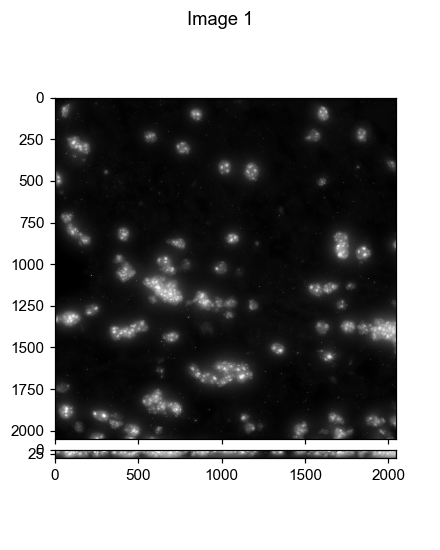

In [58]:
ia.visual_tools.imshow_mark_3d_v2([dapi_im])

In [6]:
import multiprocessing as mp
# savefile for segmentations
_total_seg_save_file = os.path.join(segmentation_folder, 'full_segmentation.hdf5')
# required parameters
microscope_file = r'\\mendel\pu_documents\Merfish_analysis\Merfish_Analysis_Scripts\merlin_parameters\microscope\storm6_microscope.json'
Zcoords = np.arange(0,12.5,0.25) # z-coordinates of all z-planes in this experiment
seg_align_params = {}
overwrite_segmentation = False
plot_segmentation = True
# initiate locks
_manager = mp.Manager()
# savefile lock
_segmentation_savefile_lock = _manager.RLock()

_seg_align_args = []
# prepare kwargs
for _fov_id, _save_filename in zip(save_fov_ids, save_filenames):
    # segmentation filename
    _segmentation_filename = os.path.join(segmentation_folder, 
        os.path.basename(_save_filename).replace('.hdf5', '_Segmentation.npy') )
    _rna_feature_filename = os.path.join(merfish_segmentation_folder, f"feature_data_{_fov_id}.hdf5")
    _rna_dapi_filename = os.path.join(merfish_dapi_folder, 
                                      os.path.basename(_save_filename).replace('.hdf5', '_Dapi.npy'))

    _args = (_fov_id, Zcoords, _rna_feature_filename, _rna_dapi_filename,
             _save_filename, microscope_file, R, 
             _total_seg_save_file, True, _segmentation_savefile_lock, 
             seg_align_params, plot_segmentation, overwrite_segmentation, False, False, True,
             )
    _seg_align_args.append(_args)
print(len(_seg_align_args))

163


In [ ]:
%%time
from ImageAnalysis3.segmentation_tools.cell import _batch_align_segmentation
# Multiprocessing
print(f"- Start multiprocessing segmentation alignment", end=' ')
_start_time = time.time()
with mp.Pool(12) as _seg_pool:
    # start multiprocessing
    _seg_pool.starmap(_batch_align_segmentation, _seg_align_args, chunksize=1)
    # close multiprocessing
    _seg_pool.close()
    _seg_pool.join()
    _seg_pool.terminate()
print(f"finish in {time.time()-_start_time:.3f}s. ")

## 2.2 Partition DNA-MERFISH spots

In [7]:
from ImageAnalysis3.classes.partition_spots import Spots_Partition
from ImageAnalysis3.classes.preprocess import Spots3D
from ImageAnalysis3.figure_tools import plot_partition
import pandas as pd

In [ ]:
%%time
from ImageAnalysis3.segmentation_tools.cell import Align_Segmentation
from ImageAnalysis3.io_tools.spots import FovCell2Spots_2_DataFrame
reload(segmentation_tools.cell)
reload(io_tools.spots)
search_radius = 3
overwrite_cand_spots = False

_partition_args = []

for _fov_id, _save_filename in zip(save_fov_ids, save_filenames):

    
    # savename
    _cand_spot_filename = os.path.join(cand_spot_folder,
                                      os.path.basename(_save_filename).replace('.hdf5', f'_CandSpots.csv') )
    
    # load segmentation label matrix and uids
    _align_seg = Align_Segmentation('', '', _save_filename, '', np.array([]))
    _align_seg._load(_total_seg_save_file)
    seg_label, fovcell_2_uid = _align_seg.dna_mask, _align_seg.fovcell_2_uid
    
    # load cand_spots_list
    with h5py.File(_save_filename, "r", libver='latest') as _f:
        _grp = _f['combo']
        combo_spots_list = [_spots[_spots[:,0]>0] for _spots in _grp['spots'][:]]
        combo_bits = _grp['ids'][:]
        combo_channels = [_ch.decode() for _ch in _grp['channels'][:]]
    # partition args
    _args = (
        _fov_id, seg_label, fovcell_2_uid, combo_spots_list, combo_bits, combo_channels,
        _cand_spot_filename, search_radius, pixel_sizes,
        True, False, False, True,
    )
    _partition_args.append(_args)
    
print(len(_partition_args))

In [14]:
%%time
from ImageAnalysis3.classes.partition_spots import _batch_partition_spots
# Multiprocessing
print(f"- Start multiprocessing spot partitioning", end=' ')
_start_time = time.time()
with mp.Pool(12) as _partition_pool:
    # start multiprocessing
    _partition_pool.starmap(_batch_partition_spots, _partition_args, chunksize=1)
    # close multiprocessing
    _partition_pool.close()
    _partition_pool.join()
    _partition_pool.terminate()
print(f"finish in {time.time()-_start_time:.3f}s. ")

- Start multiprocessing spot partitioning finish in 1277.107s. 
Wall time: 21min 17s


# 2.3 partition sequential spots

In [16]:
sequential_cand_spot_folder = os.path.join(save_folder, 'CandSpots', 'Sequential')
if not os.path.exists(sequential_cand_spot_folder):
    os.makedirs(sequential_cand_spot_folder)
    print(f"Creating sequential_cand_spot_folder: {sequential_cand_spot_folder}")
else:
    print(f"Use sequential_cand_spot_folder: {sequential_cand_spot_folder}")


Creating sequential_cand_spot_folder: \\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208\CandSpots\Sequential


In [10]:
%%time
from ImageAnalysis3.segmentation_tools.cell import Align_Segmentation
from ImageAnalysis3.io_tools.spots import FovCell2Spots_2_DataFrame
reload(segmentation_tools.cell)
reload(io_tools.spots)
search_radius = 3
overwrite_cand_spots = False

_partition_args = []

for _fov_id, _save_filename in zip(save_fov_ids, save_filenames):

    
    # savename
    _cand_spot_filename = os.path.join(sequential_cand_spot_folder, 
                                      os.path.basename(_save_filename).replace('.hdf5', f'_SequentialCandSpots.csv') )
    
    # load segmentation label matrix and uids
    _align_seg = Align_Segmentation('', '', _save_filename, '', np.array([]))
    _align_seg._load(_total_seg_save_file)
    seg_label, fovcell_2_uid = _align_seg.dna_mask, _align_seg.fovcell_2_uid
    
    # load cand_spots_list
    with h5py.File(_save_filename, "r", libver='latest') as _f:
        _grp = _f['unique']
        unique_spots_list = [_spots[_spots[:,0]>0] for _spots in _grp['spots'][:]]
        unique_bits = _grp['ids'][:]
        unique_channels = [_ch.decode() for _ch in _grp['channels'][:]]
    # partition args
    _args = (
        _fov_id, seg_label, fovcell_2_uid, unique_spots_list, unique_bits, unique_channels,
        _cand_spot_filename, search_radius, pixel_sizes,
        True, False, False, True,
    )
    _partition_args.append(_args)
    
print(len(_partition_args))

2022-03-04 14:14:05,273 [INFO] WRITING LOG OUTPUT TO C:\Users\puzheng\.cellpose\run.log
-- loading segmentation info from fov:0 into file: \\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208\Segmentation\Tests\full_segmentation.hdf5
-- loading segmentation info from fov:1 into file: \\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208\Segmentation\Tests\full_segmentation.hdf5
-- loading segmentation info from fov:2 into file: \\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208\Segmentation\Tests\full_segmentation.hdf5
-- loading segmentation info from fov:3 into file: \\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208\Segmentation\Tests\full_segmentation.hdf5
-- loading segmentation info from fov:4 into file: \\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208\Segmentation\Tests\full_segmentation.hdf5
-- loading segmentation info from fov:5 into file: \\mendel\Mendel_SSD1\Pu_Temp\2022021

-- loading segmentation info from fov:49 into file: \\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208\Segmentation\Tests\full_segmentation.hdf5
-- loading segmentation info from fov:50 into file: \\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208\Segmentation\Tests\full_segmentation.hdf5
-- loading segmentation info from fov:51 into file: \\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208\Segmentation\Tests\full_segmentation.hdf5
-- loading segmentation info from fov:52 into file: \\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208\Segmentation\Tests\full_segmentation.hdf5
-- loading segmentation info from fov:53 into file: \\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208\Segmentation\Tests\full_segmentation.hdf5
-- loading segmentation info from fov:54 into file: \\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208\Segmentation\Tests\full_segmentation.hdf5
-- l

-- loading segmentation info from fov:99 into file: \\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208\Segmentation\Tests\full_segmentation.hdf5
-- loading segmentation info from fov:100 into file: \\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208\Segmentation\Tests\full_segmentation.hdf5
-- loading segmentation info from fov:101 into file: \\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208\Segmentation\Tests\full_segmentation.hdf5
-- loading segmentation info from fov:102 into file: \\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208\Segmentation\Tests\full_segmentation.hdf5
-- loading segmentation info from fov:103 into file: \\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208\Segmentation\Tests\full_segmentation.hdf5
-- loading segmentation info from fov:104 into file: \\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208\Segmentation\Tests\full_segmentation.hdf5

-- loading segmentation info from fov:149 into file: \\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208\Segmentation\Tests\full_segmentation.hdf5
-- loading segmentation info from fov:150 into file: \\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208\Segmentation\Tests\full_segmentation.hdf5
-- loading segmentation info from fov:151 into file: \\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208\Segmentation\Tests\full_segmentation.hdf5
-- loading segmentation info from fov:152 into file: \\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208\Segmentation\Tests\full_segmentation.hdf5
-- loading segmentation info from fov:153 into file: \\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208\Segmentation\Tests\full_segmentation.hdf5
-- loading segmentation info from fov:154 into file: \\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208\Segmentation\Tests\full_segmentation.hdf

In [12]:
_partition_args[0][3]

(589, 11)

In [13]:
%%time
from ImageAnalysis3.classes.partition_spots import _batch_partition_spots
# Multiprocessing
print(f"- Start multiprocessing spot partitioning", end=' ')
_start_time = time.time()
with mp.Pool(44) as _partition_pool:
    # start multiprocessing
    _partition_pool.starmap(_batch_partition_spots, _partition_args, chunksize=1)
    # close multiprocessing
    _partition_pool.close()
    _partition_pool.join()
    _partition_pool.terminate()
print(f"finish in {time.time()-_start_time:.3f}s. ")

- Start multiprocessing spot partitioning finish in 3844.389s. 
Wall time: 1h 4min 4s


## Select dynamic background for sequential

In [23]:
# load all DF
seq_spot_filenames = [os.path.join(sequential_cand_spot_folder, _fl) 
                      for _fl in os.listdir(sequential_cand_spot_folder)
                      if '.csv' in _fl]

    break

In [49]:
%%time
fovcell_2_ints = {}

for _fl in seq_spot_filenames:
    _df = pd.read_csv(_fl, )
    if len(_df) ==0:
        continue
    # get fov_id
    _fov_id = np.unique(_df['fov_id'])[0]
    print(_fov_id)
    for _cell_id in np.unique(_df['cell_id']):
        _cell_df = _df.loc[_df['cell_id']==_cell_id]
        _cell_vec = []
        for _bit in unique_bits:
            #print(_bit, _cell_df['bit'].values)
            if _bit in _cell_df['bit'].values:
                _cell_vec.append(np.max(_cell_df.loc[_cell_df['bit']==_bit, 'height']))
            else:
                _cell_vec.append(np.nan)
        # append
        fovcell_2_ints[(_fov_id,_cell_id)] = np.array(_cell_vec)

max_ints = np.array(list(fovcell_2_ints.values()))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
Wall time: 3min 9s


<IPython.core.display.Javascript object>


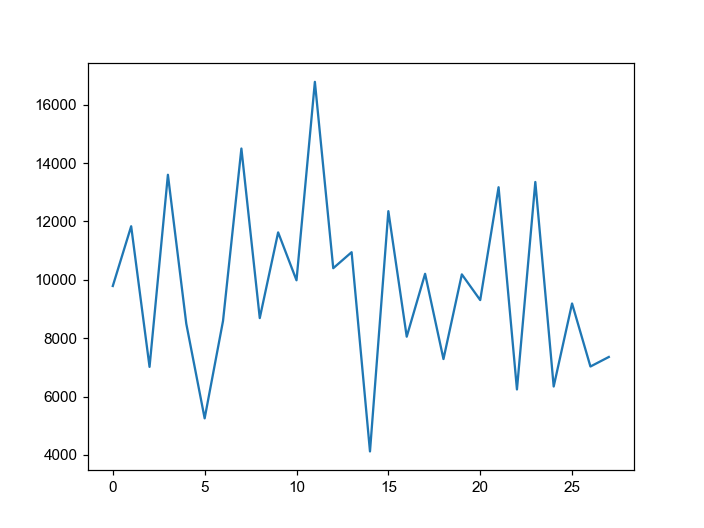

In [54]:
plt.figure()
plt.plot(np.nanmedian(max_ints, axis=0))
plt.show()

In [37]:
_cell_df.loc[_cell_df['bit']==_bit]

,fov_id,cell_id,height,z,x,y,background,sigma_z,sigma_x,sigma_y,sin_t,sin_p,eps,bit,channel,uid,pixel_z,pixel_x,pixel_y


In [28]:
_ints = []
for _bit in np.unique(_df['bit']):
    _ints.append(_df.loc[_df['bit']==_bit, 'height'].values)

<IPython.core.display.Javascript object>


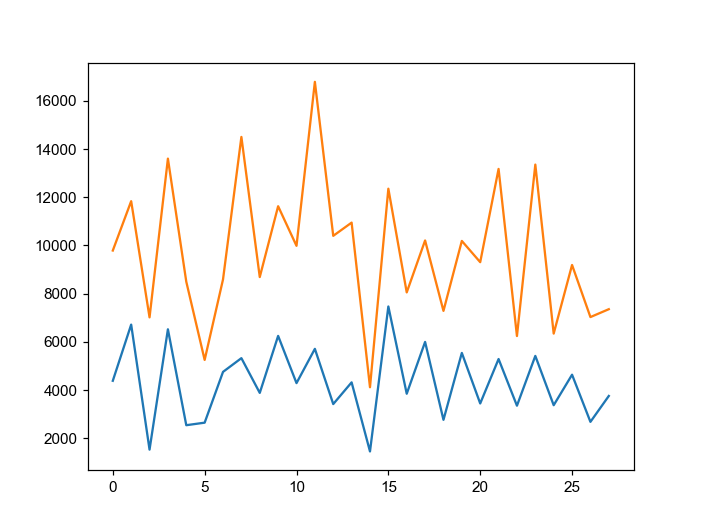

In [30]:
plt.figure()
plt.plot([np.median(_is) for _is in _ints] )
plt.show()

# 3. Decoding of DNA-MERFISH

## 3.1 load codebook

In [6]:
import pandas as pd
codebook_filename = r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\Summary_tables\CTP11-mouse-genome-1000_codebook.csv'
#
codebook_df = pd.read_csv(codebook_filename, header=0)
codebook_df

,name,id,NDB_784,NDB_755,NDB_826,NDB_713,NDB_865,NDB_725,NDB_817,NDB_710,...,NDB_824,NDB_712,NDB_818,NDB_940,NDB_872,NDB_934,NDB_926,NDB_910,chr,chr_order
0,1:3740000-3760000,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1:6240000-6260000,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
2,1:8740000-8760000,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,2
3,1:11240000-11260000,4,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,3
4,1:13740000-13760000,5,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
983,X:161240000-161260000,1057,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,X,52
984,X:163740000-163760000,1058,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,X,53
985,X:166240000-166260000,1059,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,X,54
986,X:168740000-168760000,1060,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,X,55


## 3.2 load spot files

In [7]:
with h5py.File(save_filenames[0], "r", libver='latest') as _f:
    _grp = _f['combo']
    combo_channels = [_ch.decode() for _ch in _grp['channels'][:]]
    combo_ids = _grp['ids'][:]
    
bit_2_channel = {_b:_ch for _b,_ch in zip(combo_ids, combo_channels)}

## 3.3 test decode one cell

In [23]:
%%time
from tqdm import tqdm
from ImageAnalysis3.classes import decode
reload(decode)

overwrite_decoder = False
pair_search_radius = 300

decode_args = []
for _fov_id, _save_filename in tqdm(zip(save_fov_ids, save_filenames)):
    #print(f"Prepare decoding args for fov: {_fov_id}")
    if _fov_id != 155:
        continue
    
    # load fov_df
    cand_spot_filename = os.path.join(cand_spot_folder,
                                      os.path.basename(_save_filename).replace('.hdf5', f'_CandSpots.csv') )
    
    if os.path.isfile(cand_spot_filename):
        _fov_spots_df = pd.read_csv(cand_spot_filename)
    else:
        continue
        
    for _cell_id in np.unique(_fov_spots_df['cell_id']):
        # get decoder filename
        _decoder_filename = os.path.join(decoder_folder, f'Fov-{_fov_id}_Cell-{_cell_id}_Decoder.hdf5')
        
        if os.path.exists(_decoder_filename):
            continue
        # get cell_df
        _cell_spots_df =_fov_spots_df[_fov_spots_df['cell_id']==_cell_id]

        _args = (_cell_spots_df, codebook_df, _decoder_filename, 
                 False, True, bit_2_channel,
                 pixel_sizes, 2, 0.1, 
                 pair_search_radius, -1, 1, 5, 0, -25, 
                 True, overwrite_decoder, False, False) 
        # append
        decode_args.append(_args)
    

print(len(decode_args))

163it [00:04, 40.31it/s]

167
Wall time: 4.58 s


In [24]:
import ImageAnalysis3.figure_tools.plot_decode
reload(ia.figure_tools.plot_decode)
reload(ia.io_tools.spots)
reload(ia.figure_tools.distmap)

<module 'ImageAnalysis3.figure_tools.distmap' from 'E:\\Users\\puzheng\\Documents\\ImageAnalysis3\\figure_tools\\distmap.py'>

In [21]:
# test run one cell
%matplotlib inline
reload(decode)
_cell_ind = 2000
decoder = decode.batch_decode_DNA(*decode_args[_cell_ind])

Not enough cand_spots (420) found, skip.


## visualize decoded spots

In [172]:
if not os.path.exists(decoder_folder):
    os.makedirs(decoder_folder)
    print(f"Creating decoder_folder: {decoder_folder}")
else:
    print(f"Use decoder_folder: {decoder_folder}")

decode_figure_folder = os.path.join(decoder_folder, 'Figures')
if not os.path.exists(decode_figure_folder):
    os.makedirs(decode_figure_folder)
    print(f"Creating decode_figure_folder: {decode_figure_folder}")
else:
    print(f"Use decode_figure_folder: {decode_figure_folder}")

Use decoder_folder: \\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208\Decoder\Tests
Use decode_figure_folder: \\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208\Decoder\Tests\Figures


In [ ]:
%matplotlib notebook

def rotate(angle):
     ax.view_init(azim=angle)
        
from matplotlib import animation

from matplotlib.cm import Reds, Blues, Spectral
fig = plt.figure(dpi=100)
ax = fig.add_subplot(projection='3d')

_zxys_list = decoder.chr_2_zxys_list['2']

for _ichr, _zxys in enumerate(_zxys_list):
    
    ax.scatter(_zxys[:,1], _zxys[:,2], _zxys[:,0],
               #cmap=Spectral, 
               color=Spectral(_ichr/(len(_zxys_list)+1)),
               #c=homolog_labels,
               alpha=0.7,
               s=3)

    ax.plot(_zxys[:,1], _zxys[:,2], _zxys[:,0], linewidth=0.5,
            alpha=0.7,
            color = Spectral( _ichr/(len(_zxys_list)+1) ) )
    
fig.show()

## 3.4 process all

In [25]:
%%time
# old version
import multiprocessing as mp

print(len(decode_args))
with mp.Pool(44) as decode_pool:
    decode_results = decode_pool.starmap(decode.batch_decode_DNA, decode_args, chunksize=1)
    decode_pool.close()
    decode_pool.join()
    decode_pool.terminate()

167
Wall time: 7min 33s


# 5. Summarize decoder

This step will detect all decoder files so it will merge fovs

In [162]:
#decoder_folder = os.path.join(save_folder, 'Decoder')
decoder_filenames = [os.path.join(decoder_folder, _fl) for _fl in os.listdir(decoder_folder) 
                     if '_Decoder.hdf5' in _fl]
print(decoder_folder, len(decoder_filenames))

\\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208\Decoder\Tests 340


In [ ]:
def batch_load_hdf5(decoder_filename, key):
    

In [166]:
key = 'chr_2_zxys_list'
with h5py.File(decoder_filenames[0], 'r') as _f:
    _grp = _f[key]
    for _info in _grp.keys():
        print(_info, type(_grp[_info]))
    

13 <class 'h5py._hl.dataset.Dataset'>
18 <class 'h5py._hl.dataset.Dataset'>
5 <class 'h5py._hl.dataset.Dataset'>
8 <class 'h5py._hl.dataset.Dataset'>
X <class 'h5py._hl.dataset.Dataset'>


In [19]:
%%time
import multiprocessing as mp
load_args = [(_fl, 'chr_2_zxys_list') for _fl in decoder_filenames]
print(len(load_args))
with mp.Pool(44) as load_pool:
    all_chr_2_zxys_list = load_pool.starmap(decode.batch_load_attr, 
                                            load_args, chunksize=1)
    load_pool.close()
    load_pool.join()
    load_pool.terminate()

# summarize
decode_filenames = [_fl for _fl,_item in zip(decoder_filenames, all_chr_2_zxys_list) if _item is not None]
all_chr_2_zxys_list = [_item for _item in all_chr_2_zxys_list if _item is not None]
print(len(all_chr_2_zxys_list))

1115
1115
Wall time: 42.9 s


In [20]:
%%time
import multiprocessing as mp
summary_args = [(_item, codebook_df) for _item in all_chr_2_zxys_list ]

print(len(summary_args))

with mp.Pool(44) as summary_pool: 
    all_zxys_list = summary_pool.starmap(decode.DNA_Merfish_Decoder.summarize_zxys_by_regions, 
                                         summary_args, chunksize=1)
    summary_pool.close()
    summary_pool.join()
    summary_pool.terminate()

1115
Wall time: 1min 17s


In [ ]:
fig, ax = plt.subplots()

In [28]:
figure_folder

NameError: name 'figure_folder' is not defined

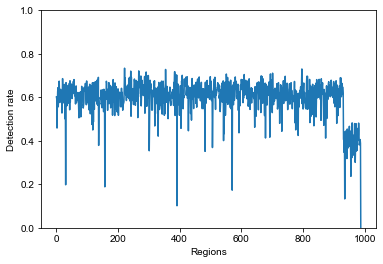

In [22]:
all_zxys = np.concatenate(all_zxys_list)
loss_rates = np.mean(np.isnan(all_zxys).any(2), axis=0)
plt.figure()
plt.plot(1-loss_rates)
plt.ylim([0,1])
plt.xlabel('Regions')
plt.ylabel('Detection rate')
plt.show()

plt.gcf().subplots_adjust(bottom=0.1, left=0.1, right=0.9,)
if save_figure:
    fig.savefig(os.path.join(figure_folder, 'all_contact_map.png'), transparent=True)
fig.show()



In [23]:
%%time
from scipy.spatial.distance import cdist,pdist,squareform
from tqdm import tqdm

all_zxys = np.concatenate(all_zxys_list)
#all_zxys = np.array(decode_save_dict['zxys'])

all_distmaps = [squareform(pdist(_zxys)) for _zxys in tqdm(all_zxys)]

from ImageAnalysis3.classes import postanalysis
median_distmap = postanalysis.parallel_reduce_matrix(all_distmaps, function='nanmedian', axis=0,
                                                     num_threads=44)

100%|███████████████████████████████████████████████████████████████████| 2230/2230 [00:30<00:00, 73.25it/s]


Wall time: 2min 2s


In [24]:
%%time
all_contactmaps = np.array(all_distmaps) <= 0.5

contactmap = postanalysis.parallel_reduce_matrix(all_contactmaps, function='nanmean', axis=0,
                                                     num_threads=44)


Wall time: 40.1 s


In [25]:
save_figure = True
#figure_folder = os.path.join(save_folder, 'Figures_final')
figure_folder = os.path.join(decoder_folder, 'Figures_final')
if not os.path.exists(figure_folder):
    print(f"Create figure_folder: {figure_folder}")
    os.makedirs(figure_folder)
else:
    print(f"Use figure_folder: {figure_folder}")

Use figure_folder: \\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208\Decoder\Figures_final


In [26]:
_ordered_chr_names = []
for _chr_name, _chr_reg_id in zip(codebook_df['chr'], codebook_df['chr_order']):
    if _chr_name not in _ordered_chr_names:
        _ordered_chr_names.append(_chr_name)
chr_2_indices = {_chr:np.array(codebook_df.loc[codebook_df['chr']==_chr].index)
                for _chr in np.unique(codebook_df['chr'].values)}

_labels_edges = np.array([0] + [np.max(chr_2_indices[_chr]) for _chr in _ordered_chr_names])

E:\Users\puzheng\AppData\anaconda3\lib\site-packages\ipykernel_launcher.py:8: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Reds"))
  


<IPython.core.display.Javascript object>


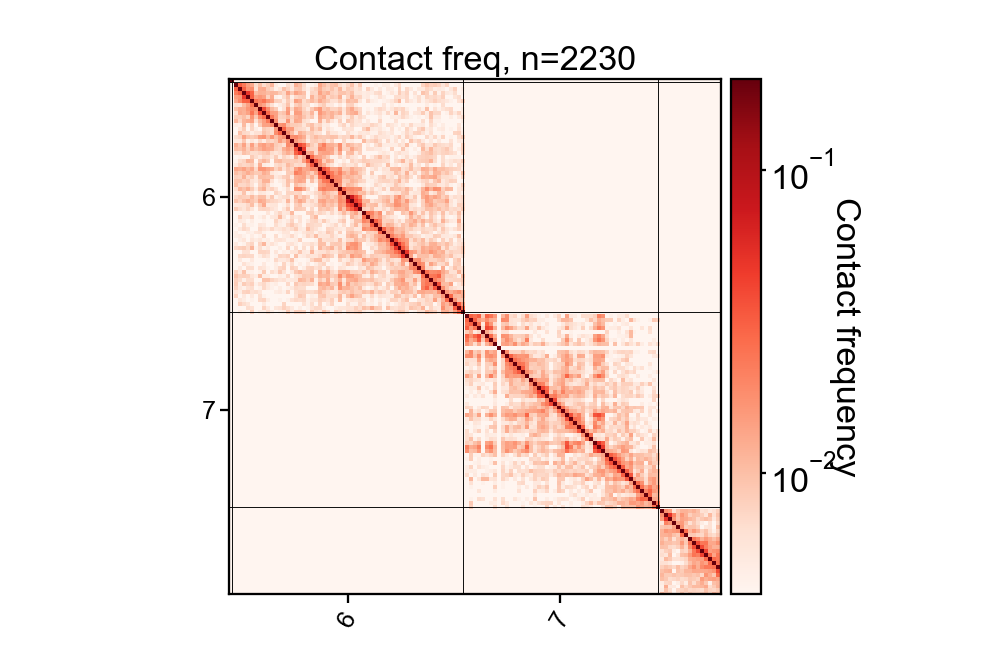

E:\Users\puzheng\Documents\ImageAnalysis3\figure_tools\distmap.py:39: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  vmin=min(color_limits), vmax=max(color_limits), **imshow_kwargs)


In [43]:
from matplotlib.colors import LogNorm
from matplotlib import cm

contact_limits = [0.004, 0.2]
contact_norm = LogNorm(vmin=np.min(contact_limits), 
                       vmax=np.max(contact_limits))
contact_cmap = cm.get_cmap('Reds')
contact_cmap.set_bad(color=[0.,0.,0.,1])

fig, ax = plt.subplots(figsize=(3,2), dpi=300)

ia.figure_tools.distmap.plot_distance_map(
    contactmap, 
    cmap=contact_cmap,
    color_limits=contact_limits,
    color_norm=contact_norm,
    colorbar_labels='Contact frequency',
    ax=ax,
)

ax.set_title(f'Contact freq, n={len(all_distmaps)}', fontsize=7.5, pad=2)

ax.set_xticks((_labels_edges[1:] + _labels_edges[:-1])/2)
ax.set_xticklabels(_ordered_chr_names, fontsize=5.5, rotation=60,)
ax.set_yticks((_labels_edges[1:] + _labels_edges[:-1])/2)
ax.set_yticklabels(_ordered_chr_names, fontsize=5.5, )

ax.hlines(_labels_edges, 0, len(median_distmap), color='black', linewidth=0.2)
ax.vlines(_labels_edges, 0, len(median_distmap), color='black', linewidth=0.2)

plt.gcf().subplots_adjust(bottom=0.1, left=0.1, right=0.9,)
if save_figure:
    fig.savefig(os.path.join(figure_folder, 'all_contact_map.png'), transparent=True)
fig.show()


<IPython.core.display.Javascript object>


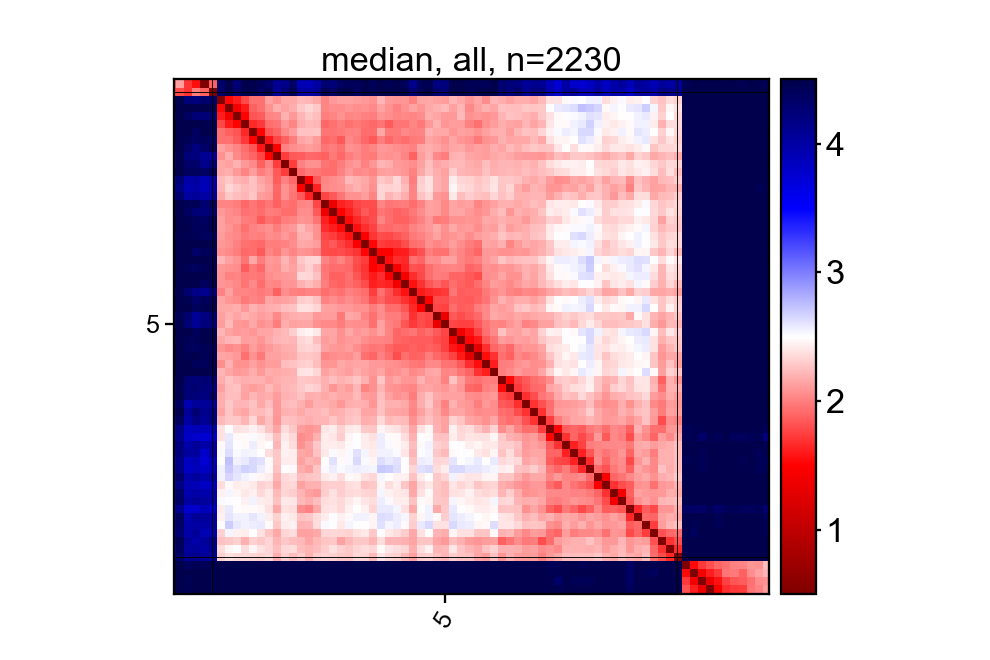

In [39]:
%matplotlib notebook

fig, ax = plt.subplots(figsize=(3,2), dpi=300)

ia.figure_tools.distmap.plot_distance_map(median_distmap, color_limits=[0.5,4.5],
                                          ax=ax,
                                          )
ax.set_title(f'median, all, n={len(all_distmaps)}', fontsize=7.5, pad=2)

ax.set_xticks((_labels_edges[1:] + _labels_edges[:-1])/2)
ax.set_xticklabels(_ordered_chr_names, fontsize=5.5, rotation=60,)
ax.set_yticks((_labels_edges[1:] + _labels_edges[:-1])/2)
ax.set_yticklabels(_ordered_chr_names, fontsize=5.5, )

ax.hlines(_labels_edges, 0, len(median_distmap), color='black', linewidth=0.2)
ax.vlines(_labels_edges, 0, len(median_distmap), color='black', linewidth=0.2)

plt.gcf().subplots_adjust(bottom=0.1, left=0.1, right=0.9,)
if save_figure:
    fig.savefig(os.path.join(figure_folder, 'all_median_distmap.png'), transparent=True)
fig.show()